# Capstone Part 3: Getting Started (hands-on)

### Tasks

    1. Build a draft version of an API with train, predict, and logfile endpoints.
    2. Using Docker, bundle your API, model, and unit tests.
    3. Using test-driven development iterate on your API in a way that anticipates scale, load, and drift.
    4. Create a post-production analysis script that investigates the relationship between model performance and the business metric.
    5. Articulate your summarized findings in a final report.

## Getting started

There are three tasks in the pieces to the final part of the case study.

    1. Ready your model for deployment
    2. Query your API with new data and test your monitoring tools
    3. Compare your results to the gold standard

#### Note: 
In reality your model would re-train itself at some cadence (e.g. nightly or weekly). If your systems is capable of this you should demonstrate this capacity as part of the deliverable. This is not a requirement of the model for this assignment, but it is an important aspect of model deployment to keep in mind.

You will need to access the following link to download the files for completing this assignment prior to continuing. Please refer to Part 3 of the Readme for additional information/instructions:
https://github.com/aavail/ai-workflow-capstone

    To ready your model for deployment you will be required to prepare you model in a way that the Flask API can both train and predict. There are some differences when you compare this model to most of those we have discussed throughout this specialization. When it comes to training one solution is that the model train script simply uses all files in a given directory. This way you could set your model up to be re-trained at regular intervals with little overhead.

    Prediction in the case of this model requires a little more thought. You are not simply passing a query corresponding to a row in a feature matrix, because this business opportunity requires that the API takes a country name and a date. There are many ways to accommodate these requirements. You model may simply save the forecasts for a range of dates, then the 'predict' function serves to looks up the specified 30 day revenue prediction. You model could also transform the target date into an appropriate input vector that is then used as input for a trained model.

    You might be tempted to setup the predict function to work only with the latest date, which would be appropriate in some circumstances, but in this case we are building a tool to fit the specific needs of individuals. Some people in leadership at AAVAIL make projections at the end of the month and others do this on the 15th so the predict function needs to work for all of the end users.

    In the case of this project you can safely assume that there are only a few individuals that will be active users of the model so it may not be worth the effort to optimize for speed when it comes to prediction or training. The important thing is to arrive at a working solution.

    Once all of your tests pass and your model is being served via Docker you will need to query the API. One suggestion for this part is to use a script to simulate the process. You may want to start with fresh log files and then for every new day make a prediction with the consideration that you have not yet seen the rest of the future data. To may the process more realistic you could 're-train' your model say every week or nightly. At a minimum you should have predictions for each day when you are finished and you should compare them to the known values.

    To monitor performance there are several plots that could be made. The time-series plot where X are the day intervals and Y is the 30 day revenue (projected and known) can be particularly useful here. Because we obtain labels for y the performance of your model can be monitored by comparing predicted and known values.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels as sm

from statsmodels.tsa.stattools import adfuller

import sklearn.metrics as sm
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')


%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
LARGE_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

In [2]:
from logger import *
from data_ingestion_lib import *
from model import *

## 1. Load data

From the original DataFrame (fetch_data()) return a numerically indexed time-series DataFrame by aggregating over each day.

In [3]:
pwd

'C:\\Users\\RenataUjhaziova\\Coursera_AI_Workflow\\CapstoneProject\\ai-workflow-capstone-master\\solution_notebooks'

In [4]:
data_dir_train = '../cs-train/'

In [5]:
## load data
ts_data = fetch_ts(data_dir_train)
ts_data

... loading ts data from files


{'all':            date  purchases  unique_invoices  unique_streams  total_views  \
 0    2017-11-01          0                0               0            0   
 1    2017-11-02          0                0               0            0   
 2    2017-11-03          0                0               0            0   
 3    2017-11-04          0                0               0            0   
 4    2017-11-05          0                0               0            0   
 ..          ...        ...              ...             ...          ...   
 602  2019-06-26       1358               67             999         6420   
 603  2019-06-27       1620               80             944         9435   
 604  2019-06-28       1027               70             607         5539   
 605  2019-06-29          0                0               0            0   
 606  2019-06-30        602               27             423         2534   
 
     year_month  revenue  
 0      2017-11     0.00  
 1      2017-

In [6]:
all_data = {}
for country, df in ts_data.items():
    X,y,dates = engineer_features(df,training=True)
    dates = np.array([str(d) for d in dates])
    all_data[country] = {"X":X,"y":y,"dates": dates}

### 1.1 Create dataframe for 'all' data 

In [7]:
df_all = all_data['all']['X']
df_all['y'] = all_data['all']['y']
df_all['dates'] = all_data['all']['dates']
df_all

,previous_7,previous_14,previous_28,previous_70,previous_year,recent_invoices,recent_views,y,dates
0,14450.54,14450.54,14450.54,14450.540,0.00,5.928571,537.392857,183857.22,2017-11-29
1,27862.50,27862.50,27862.50,27862.500,0.00,10.310345,1007.103448,170445.26,2017-11-30
2,41152.75,41152.75,41152.75,41152.750,0.00,14.966667,1499.066667,157155.01,2017-12-01
3,50840.03,50840.03,50840.03,50840.030,0.00,18.533333,1916.533333,147467.73,2017-12-02
4,52283.29,52283.29,52283.29,52283.290,0.00,19.600000,2026.966667,147991.02,2017-12-03
...,...,...,...,...,...,...,...,...,...
544,35654.01,88316.24,184306.67,378375.021,223505.56,70.000000,6702.533333,195395.17,2019-05-27
545,23045.09,67418.62,184306.67,375436.261,227317.94,70.000000,6702.533333,200298.34,2019-05-28
546,20834.33,62382.30,160811.46,370127.071,234869.69,71.366667,6839.200000,200717.34,2019-05-29
547,22111.84,62893.44,163049.25,371180.251,237016.78,73.533333,7026.733333,198456.74,2019-05-30


### 1.2 Create dataframe for 'united kingdom' data 

In [8]:
df_uk = all_data['united_kingdom']['X']
df_uk['y'] = all_data['united_kingdom']['y']
df_uk['dates'] = all_data['united_kingdom']['dates']
df_uk

,previous_7,previous_14,previous_28,previous_70,previous_year,recent_invoices,recent_views,y,dates
0,13281.12,13281.12,13281.12,13281.120,0.00,5.500000,461.500000,173959.95,2017-11-29
1,26504.09,26504.09,26504.09,26504.090,0.00,9.620690,916.275862,160736.98,2017-11-30
2,39445.59,39445.59,39445.59,39445.590,0.00,14.100000,1393.833333,147795.48,2017-12-01
3,48608.66,48608.66,48608.66,48608.660,0.00,17.433333,1782.233333,138632.41,2017-12-02
4,49871.94,49871.94,49871.94,49871.940,0.00,18.466667,1885.600000,139305.39,2017-12-03
...,...,...,...,...,...,...,...,...,...
544,27077.89,75420.91,164870.89,332139.731,214887.55,64.033333,5784.000000,174379.16,2019-05-27
545,21415.85,55184.21,164870.89,329400.071,217886.64,64.033333,5784.000000,178990.16,2019-05-28
546,18685.65,50822.41,141209.24,324094.101,224261.42,65.100000,5887.633333,179677.32,2019-05-29
547,20229.09,51554.17,143412.75,325326.831,225882.00,67.000000,6052.166667,177184.65,2019-05-30


## 2. Create different models and compare the results

### 2.1 Random forest regression

In [9]:
def train_model_rf_reg(X,y):    
    ## Perform a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=42)
    ## train a random forest model
    param_grid_rf = {
    'rf__criterion': ['mse','mae'],
    'rf__n_estimators': [10,15,20,25]
    }

    pipe_rf = Pipeline(steps=[('scaler', StandardScaler()),
                              ('rf', RandomForestRegressor())])
    
    grid = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=5, iid=False, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    
    # print best parameters
    print('Best parameters of the model: ', grid.best_params_)
    print('Best score of the model: ', grid.best_score_)
    
    # print model evaluation results
    eval_rmse =  round(np.sqrt(mean_squared_error(y_test,y_pred)))
    print('RMSE: ' , eval_rmse)
    print('STD: ' , round(np.std(y_pred-y_test),3))    
    print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2)) 
    print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 2)) 
    print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2)) 
    print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2)) 
    print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))
  
    ## retrain using all data
    # grid.fit(X, y)

In [10]:
train_model_rf_reg(X = df_all.drop(columns=['y','dates']),y = df_all['y'])

Best parameters of the model:  {'rf__criterion': 'mse', 'rf__n_estimators': 25}
Best score of the model:  0.9127835298064984
RMSE:  15658.0
STD:  15626.977
Mean absolute error = 11318.24
Mean squared error = 245157448.67
Median absolute error = 7783.81
Explain variance score = 0.96
R2 score = 0.96


In [11]:
train_model_rf_reg(X = df_uk.drop(columns=['y','dates']),y = df_uk['y'])

Best parameters of the model:  {'rf__criterion': 'mse', 'rf__n_estimators': 25}
Best score of the model:  0.9240545491859
RMSE:  16993.0
STD:  16961.728
Mean absolute error = 10918.21
Mean squared error = 288751458.79
Median absolute error = 5989.75
Explain variance score = 0.95
R2 score = 0.95


### 2.2 XGboost regressor

In [12]:
def train_model_xg(X,y):    
    ## Perform a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=42)
    
    # A parameter grid for XGBoost
    param_grid = {'min_child_weight':[4,5], 
                  'gamma':[i/10.0 for i in range(3,6)],  
                  'subsample':[i/10.0 for i in range(6,11)],
                  'colsample_bytree':[i/10.0 for i in range(6,11)], 
                  'max_depth': [2,3,4]}
    

    # Initialize XGB and GridSearch
    xgb = XGBRegressor(nthread=-1) 
        
    grid = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    print('Best Score: ', grid.best_score_)
    print('Best Params: ', grid.best_params_)
    
    # print model evaluation results
    eval_rmse =  round(np.sqrt(mean_squared_error(y_test,y_pred)))
    print('RMSE: ' , eval_rmse)
    print('STD: ' , round(np.std(y_pred-y_test),3))    
    print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2)) 
    print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 2)) 
    print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2)) 
    print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2)) 
    print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))
  
    ## retrain using all data
    # grid.fit(X, y)

In [13]:
train_model_xg(X = df_all.drop(columns=['y','dates']),y = df_all['y'])

C:\Users\RenataUjhaziova\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 450 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   59.4s finished
C:\Users\RenataUjhaziova\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:57:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score:  0.895079767898833
Best Params:  {'colsample_bytree': 0.6, 'gamma': 0.3, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8}
RMSE:  20151.0
STD:  20111.378
Mean absolute error = 15240.88
Mean squared error = 406050626.89
Median absolute error = 11042.11
Explain variance score = 0.94
R2 score = 0.94


In [14]:
train_model_xg(X = df_uk.drop(columns=['y','dates']),y = df_uk['y'])

C:\Users\RenataUjhaziova\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 450 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  1.0min finished
C:\Users\RenataUjhaziova\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:58:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score:  0.9045061844806134
Best Params:  {'colsample_bytree': 1.0, 'gamma': 0.3, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 1.0}
RMSE:  25661.0
STD:  25525.777
Mean absolute error = 15223.8
Mean squared error = 658480047.91
Median absolute error = 8330.6
Explain variance score = 0.9
R2 score = 0.9


### 2.3 Ridge regression

In [15]:
def train_model_rg(X,y):    
    ## Perform a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=42)
    
    # Train model with default alpha=1
    ridge = Ridge(alpha=1).fit(X_train, y_train)
    
    # find optimal alpha with grid search
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    param_grid = dict(alpha=alpha)
    
    grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', verbose=0, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    print('Best Score: ', grid.best_score_)
    print('Best Params: ', grid.best_params_)
    
    # print model evaluation results
    eval_rmse =  round(np.sqrt(mean_squared_error(y_test,y_pred)))
    print('RMSE: ' , eval_rmse)
    print('STD: ' , round(np.std(y_pred-y_test),3))    
    print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2)) 
    print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 2)) 
    print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2)) 
    print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2)) 
    print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))
  
    ## retrain using all data
    # grid.fit(X, y)

In [16]:
train_model_rg(X = df_all.drop(columns=['y','dates']),y = df_all['y'])

C:\Users\RenataUjhaziova\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score:  0.4735363113785238
Best Params:  {'alpha': 1000}
RMSE:  55538.0
STD:  55241.166
Mean absolute error = 43429.12
Mean squared error = 3084429543.12
Median absolute error = 35867.06
Explain variance score = 0.53
R2 score = 0.53


In [17]:
train_model_rg(X = df_uk.drop(columns=['y','dates']),y = df_uk['y'])

C:\Users\RenataUjhaziova\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score:  0.4833997420774578
Best Params:  {'alpha': 1000}
RMSE:  52964.0
STD:  52686.379
Mean absolute error = 39938.64
Mean squared error = 2805155136.64
Median absolute error = 33534.17
Explain variance score = 0.56
R2 score = 0.56


### 2.4 Lasso regression

In [18]:
def train_model_lr(X,y):    
    ## Perform a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=42)
    
    lasso = Lasso(alpha=1).fit(X_train, y_train)
    
    # find optimal alpha with grid search
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    param_grid = dict(alpha=alpha)
    
    grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', verbose=0, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    print('Best Score: ', grid.best_score_)
    print('Best Params: ', grid.best_params_)
    
    # print model evaluation results
    eval_rmse =  round(np.sqrt(mean_squared_error(y_test,y_pred)))
    print('RMSE: ' , eval_rmse)
    print('STD: ' , round(np.std(y_pred-y_test),3))    
    print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2)) 
    print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 2)) 
    print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2)) 
    print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2)) 
    print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))
  
    ## retrain using all data
    # grid.fit(X, y)

In [19]:
train_model_lr(X = df_all.drop(columns=['y','dates']),y = df_all['y'])

C:\Users\RenataUjhaziova\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score:  0.47320071163151195
Best Params:  {'alpha': 1000}
RMSE:  55552.0
STD:  55251.359
Mean absolute error = 43445.48
Mean squared error = 3086017336.66
Median absolute error = 36072.84
Explain variance score = 0.53
R2 score = 0.53


In [20]:
train_model_lr(X = df_uk.drop(columns=['y','dates']),y = df_uk['y'])

C:\Users\RenataUjhaziova\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score:  0.48308657754517703
Best Params:  {'alpha': 1000}
RMSE:  52969.0
STD:  52690.106
Mean absolute error = 39944.67
Mean squared error = 2805745907.68
Median absolute error = 33485.26
Explain variance score = 0.56
R2 score = 0.56


#### Conclusion:
 The best model is Random forrest regressor. 

## 3. Plot learning curve

In [21]:
def plot_learning_curve(estimator, X, y,ax=None, save_as=None, cv=5):
    """
    an sklearn estimator 
    """

    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    train_sizes=np.linspace(.1, 1.0, 6)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv, n_jobs=-1,
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ## axes and lables
    buff = 0.05
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xbuff = buff * (xmax - xmin)
    ybuff = buff * (ymax - ymin)
    ax.set_xlim(xmin-xbuff,xmax+xbuff)
    ax.set_ylim(ymin-ybuff,ymax+ybuff)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    
    ax.legend(loc="best")

### 3.1 Plot learning curve for dataset from all countries

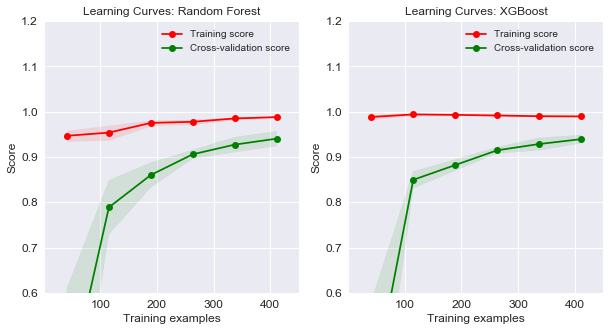

In [22]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.25, random_state=0)

estimator = RandomForestRegressor(criterion= 'mae', n_estimators=20)
plot_learning_curve(estimator, 
                    X = df_all.drop(columns=['y','dates']),y = df_all['y'],
                    ax=ax1,cv=5)
#title = "Learning Curves (XGBoost)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = XGBRegressor(colsample_bytree= 0.6, 
                          gamma= 0.3, 
                          max_depth= 4, 
                          min_child_weight= 4, 
                          subsample= 0.8)
plot_learning_curve(estimator, X = df_all.drop(columns=['y','dates']),y = df_all['y'],
                    ax=ax2,cv=5)

ax1.set_title("Learning Curves: Random Forest")
ax2.set_title("Learning Curves: XGBoost")

for ax in [ax1,ax2]:
        ax.set_ylim((0.6,1.2))
    
plt.show()

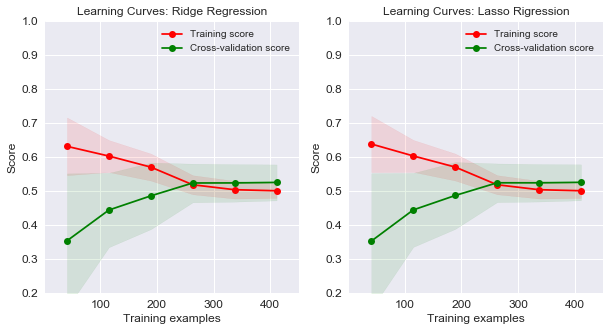

In [23]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.25, random_state=0)

estimator = Ridge(alpha=1000)
plot_learning_curve(estimator, 
                    X = df_all.drop(columns=['y','dates']),y = df_all['y'],
                    ax=ax1,cv=5)

cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = Lasso(alpha=1000)
plot_learning_curve(estimator, X = df_all.drop(columns=['y','dates']),y = df_all['y'],
                    ax=ax2,cv=5)

ax1.set_title("Learning Curves: Ridge Regression")
ax2.set_title("Learning Curves: Lasso Rigression")

for ax in [ax1,ax2]:
        ax.set_ylim((0.2,1.0))
    
plt.show()

### 3.2 Plot learning curve for United Kingdom 

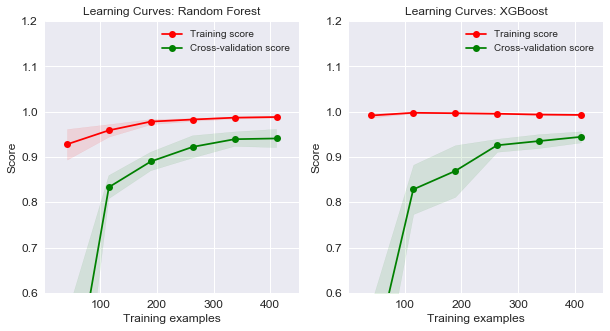

In [24]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.25, random_state=0)

estimator = RandomForestRegressor(criterion= 'mse', n_estimators=20)
plot_learning_curve(estimator, 
                    X = df_uk.drop(columns=['y','dates']),y = df_uk['y'],
                    ax=ax1,cv=5)
#title = "Learning Curves (XGBoost)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = XGBRegressor(colsample_bytree= 1.0, 
                          gamma= 0.3, 
                          max_depth= 4, 
                          min_child_weight= 4, 
                          subsample= 1.0)
plot_learning_curve(estimator, 
                    X = df_uk.drop(columns=['y','dates']),y = df_uk['y'],
                    ax=ax2,cv=5)

ax1.set_title("Learning Curves: Random Forest")
ax2.set_title("Learning Curves: XGBoost")

for ax in [ax1,ax2]:
        ax.set_ylim((0.6,1.2))
    
plt.show()

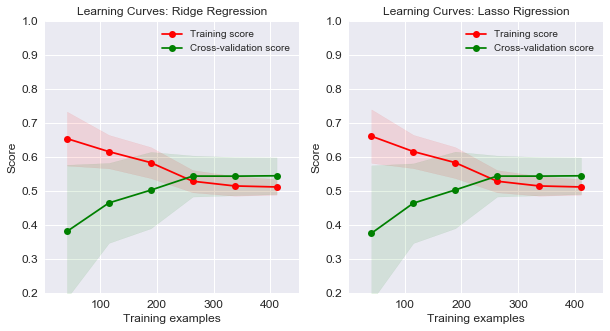

In [25]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.25, random_state=0)

estimator = Ridge(alpha=1000)
plot_learning_curve(estimator, 
                    X = df_uk.drop(columns=['y','dates']),y = df_uk['y'],
                    ax=ax1,cv=5)

cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = Lasso(alpha=1000)
plot_learning_curve(estimator, 
                    X = df_uk.drop(columns=['y','dates']),y = df_uk['y'],
                    ax=ax2,cv=5)

ax1.set_title("Learning Curves: Ridge Regression")
ax2.set_title("Learning Curves: Lasso Rigression")

for ax in [ax1,ax2]:
        ax.set_ylim((0.2,1.0))
    
plt.show()

## 4. Re-train your model on all of the data using the selected approach & prepare it for deployment

### 3.1 Train model on selected data using the selected approach

In [26]:
model_train(data_dir_train,test=True)

... test flag on
...... subseting data
...... subseting countries
... loading ts data from files
... saving test version of model: ../models\test-all-0_1.joblib
... saving test version of model: ../models\test-united_kingdom-0_1.joblib


### 3.2 Re-train model on all of the data using the selected approach and prepare it for deployment

In [27]:
model_train(data_dir_train,test=False)

... loading ts data from files
... saving model: ../models\sl-all-0_1.joblib
... saving model: ../models\sl-eire-0_1.joblib
... saving model: ../models\sl-france-0_1.joblib
... saving model: ../models\sl-germany-0_1.joblib
... saving model: ../models\sl-hong_kong-0_1.joblib
... saving model: ../models\sl-netherlands-0_1.joblib
... saving model: ../models\sl-norway-0_1.joblib
... saving model: ../models\sl-portugal-0_1.joblib
... saving model: ../models\sl-singapore-0_1.joblib
... saving model: ../models\sl-spain-0_1.joblib
... saving model: ../models\sl-united_kingdom-0_1.joblib
